In [1113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from datetime import date
import sklearn
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [1114]:
train = pd.read_csv("train_v9rqX0R.csv")

In [1115]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [1116]:
train.shape

(8523, 12)

In [1117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [1118]:
train.isnull().sum()# so clearly Item_Weight and Outlet_Size have 17% and 28% null so we must need to impute them with proper values

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [1119]:
train[train.duplicated()]# so there are no dublicated rows

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [1120]:
train['Item_Identifier'].value_counts()# there are around 1559 different identifier 

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

In [1121]:
# extracting the first two character as they are repetatly used in the identifier which may be to define starting of any type of item.
train['Item_Identifier_catagory'] = train['Item_Identifier'].str[:2]

In [1122]:
train['Item_Identifier_catagory'].value_counts()

Item_Identifier_catagory
FD    6125
NC    1599
DR     799
Name: count, dtype: int64

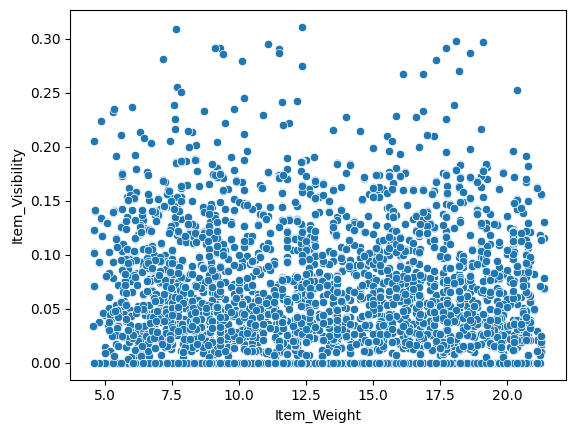

In [1123]:
sns.scatterplot(data=train, x='Item_Weight', y='Item_Visibility')

plt.show()

In [1124]:
train['Item_Weight'].corr(train['Item_Visibility'])# so -0.014047725947827284 is the corelation btw item weight and item visibility
# so there is almost no corelationship between this two

np.float64(-0.014047725947827284)

In [1125]:
# Now trying to impute Item_Weight based on three following ways:
# 1- Impute Itemweight based on Item_Identifier
# 2- Item weight may be dependent on basis of Item_Identifier_catagory and Item_Type
# 3- Impute with mean or median
# 4- Impute with linear interpolation between two values

<Axes: ylabel='Density'>

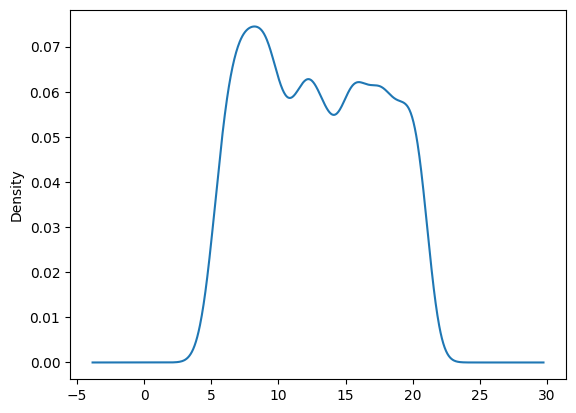

In [1126]:
train['Item_Weight'].plot(kind='kde')# data distribution of item weight

In [1127]:
# logic to calculate outliers based on Z-score formula and a value is considered as outlier when the value lies outside
# three standered distribution

y=[]
def find_outliers(a):
    threshold=3
    mean=np.mean(a)
    std=np.std(a)
    for i in a:
        z_score=(i-mean)/std
        if abs(z_score)>threshold:
            y.append(i)
    return len(y)
print(find_outliers(train['Item_Weight']))

0


In [1128]:
# item weight based on identifier
train.groupby('Item_Identifier')['Item_Weight'].mean()

Item_Identifier
DRA12    11.600
DRA24    19.350
DRA59     8.270
DRB01     7.390
DRB13     6.115
          ...  
NCZ30     6.590
NCZ41    19.850
NCZ42    10.500
NCZ53     9.600
NCZ54    14.650
Name: Item_Weight, Length: 1559, dtype: float64

In [1129]:
train['Item_Weight_based_on_identifier'] = train['Item_Weight'].fillna(
    train.groupby('Item_Identifier')['Item_Weight'].transform('mean')
)

<Axes: ylabel='Density'>

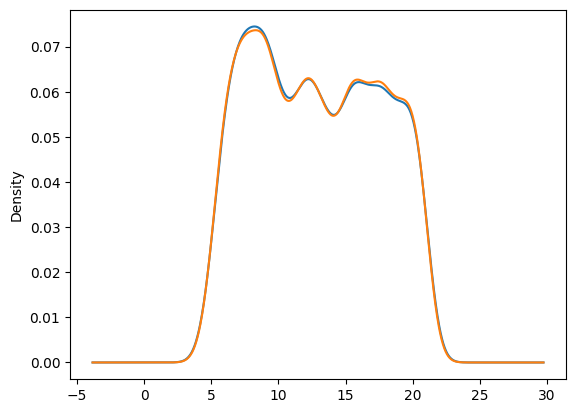

In [1130]:
train['Item_Weight'].plot(kind='kde')
train['Item_Weight_based_on_identifier'].plot(kind='kde')
# as we can see with this both the graphs are very close to each other

In [1131]:
train.groupby(['Item_Identifier_catagory','Item_Type'])['Item_Weight'].mean()

Item_Identifier_catagory  Item_Type            
DR                        Dairy                    13.827331
                          Hard Drinks              11.400328
                          Soft Drinks              11.847460
FD                        Baking Goods             12.277108
                          Breads                   11.346936
                          Breakfast                12.768202
                          Canned                   12.305705
                          Dairy                    13.320379
                          Frozen Foods             12.867061
                          Fruits and Vegetables    13.224769
                          Meat                     12.817344
                          Seafood                  12.552843
                          Snack Foods              12.987880
                          Starchy Foods            13.690731
NC                        Health and Hygiene       13.142314
                          Household  

In [1132]:
# trying to impute Item_Weight based on Item_Identifier_catagory and Item_Type
train['Item_Weight_new'] = train['Item_Weight'].fillna(
    train.groupby(['Item_Identifier_catagory', 'Item_Type'])['Item_Weight'].transform('mean')
)

<Axes: ylabel='Density'>

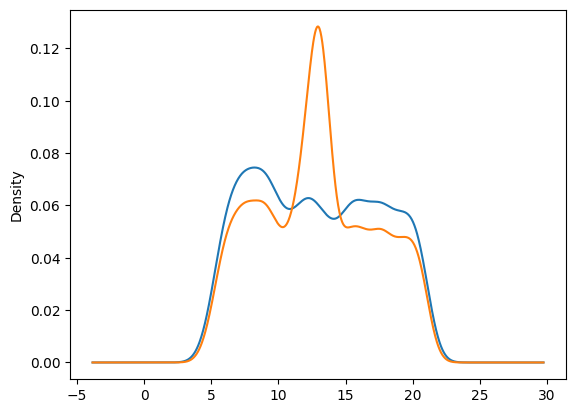

In [1133]:
train['Item_Weight'].plot(kind='kde')
train['Item_Weight_new'].plot(kind='kde')
# so here if we impute item weight with Item_Identifier_catagory and Item_Type we can see a high value between 10 to 15

In [1134]:
train['Item_Weight'].mean(), train['Item_Weight'].median()# so we can see both mean and median is almost same so the data might be symmetric

(np.float64(12.857645184135976), np.float64(12.6))

<Axes: ylabel='Density'>

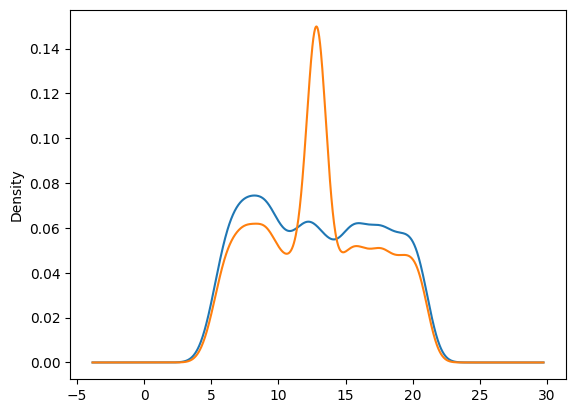

In [1135]:
# so imputing item weight with mean and then check the distribution
train['Item_Weight_mean']=train['Item_Weight'].fillna(train['Item_Weight'].mean())
train['Item_Weight'].plot(kind='kde')
train['Item_Weight_mean'].plot(kind='kde')

In [1136]:
# the above graph is also similar to the graph when we impute Item_Weight based on Item_Identifier_catagory and Item_Type

<Axes: ylabel='Density'>

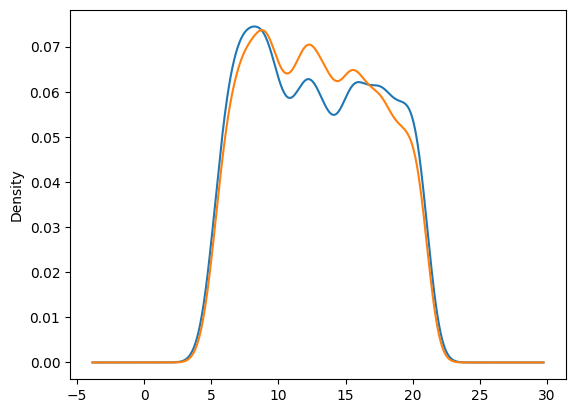

In [1137]:
# trying with interpolation
train['Item_Weight_interpolate']=train['Item_Weight'].fillna(train['Item_Weight'].interpolate(method='linear')) 
train['Item_Weight'].plot(kind='kde')
train['Item_Weight_interpolate'].plot(kind='kde')

In [1138]:
#so the above graph is also following the actual graph without interpolation patten but has a small difference between 10 to 20

In [1139]:
# So among all the approach Impute Itemweight based on Item_Identifier stands out to be the best approach and
# the column used is Item_Weight_based_on_identifier

In [1140]:
train.isnull().sum()

Item_Identifier                       0
Item_Weight                        1463
Item_Fat_Content                      0
Item_Visibility                       0
Item_Type                             0
Item_MRP                              0
Outlet_Identifier                     0
Outlet_Establishment_Year             0
Outlet_Size                        2410
Outlet_Location_Type                  0
Outlet_Type                           0
Item_Outlet_Sales                     0
Item_Identifier_catagory              0
Item_Weight_based_on_identifier       4
Item_Weight_new                       0
Item_Weight_mean                      0
Item_Weight_interpolate               0
dtype: int64

In [1141]:
# need to inpute the remaning 4 values of Item_Weight_based_on_identifier column

In [1142]:
train['Item_Weight_based_on_identifier'] = train['Item_Weight_based_on_identifier'].fillna(
    train.groupby(['Item_Identifier_catagory', 'Item_Type'])['Item_Weight_based_on_identifier'].transform('mean')
)

In [1143]:
# imputing Item_Weight_based_on_identifier based on 'Item_Identifier_catagory' and 'Item_Type'

<Axes: ylabel='Density'>

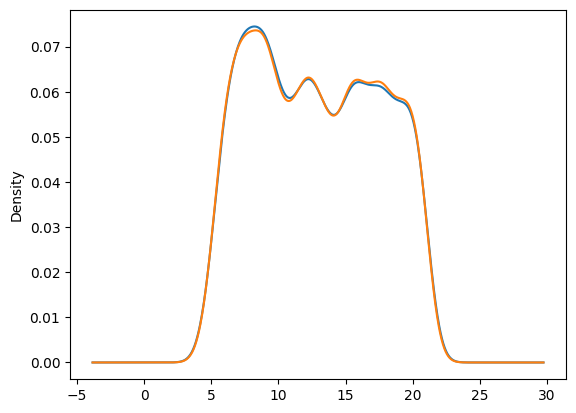

In [1144]:
train['Item_Weight'].plot(kind='kde')
train['Item_Weight_based_on_identifier'].plot(kind='kde')

In [1145]:
train.isnull().sum()

Item_Identifier                       0
Item_Weight                        1463
Item_Fat_Content                      0
Item_Visibility                       0
Item_Type                             0
Item_MRP                              0
Outlet_Identifier                     0
Outlet_Establishment_Year             0
Outlet_Size                        2410
Outlet_Location_Type                  0
Outlet_Type                           0
Item_Outlet_Sales                     0
Item_Identifier_catagory              0
Item_Weight_based_on_identifier       0
Item_Weight_new                       0
Item_Weight_mean                      0
Item_Weight_interpolate               0
dtype: int64

<Axes: xlabel='Item_Fat_Content', ylabel='count'>

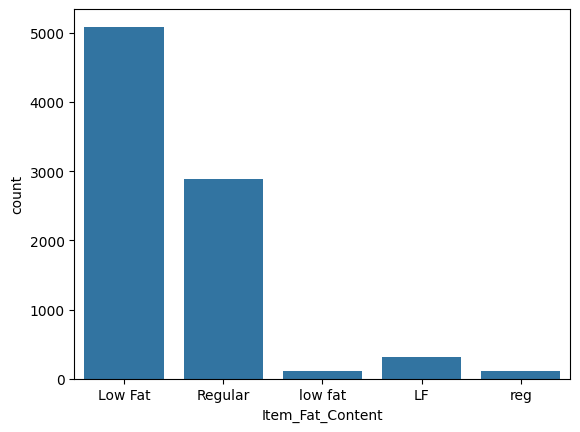

In [1146]:
sns.countplot(data=train,x='Item_Fat_Content')

In [1147]:
# Observation Low Fat, low fat and LF belong to same catagory so we can rename to Low Fat
# Regular and reg is also same so we will rename it to Regular
train['Item_Fat_Content'] = train['Item_Fat_Content'].map({
    'Low Fat': 'Low Fat',
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular',
    'Regular': 'Regular'
})

In [1148]:
train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [1149]:
train['Item_Visibility'].value_counts()

Item_Visibility
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: count, Length: 7880, dtype: int64

In [1150]:
# So we can see lot of Zero in Item_Visibility column which indicate bad data as visibility cant be completely zero.

In [1151]:
# we will use Item_Identifier or Item type to calculate mean of Item_Visibility and check which ones distribution is better

In [1152]:
train['Item_Visibility'].mean(),train['Item_Visibility'].median()

(np.float64(0.06613202877895108), np.float64(0.053930934))

<Axes: ylabel='Density'>

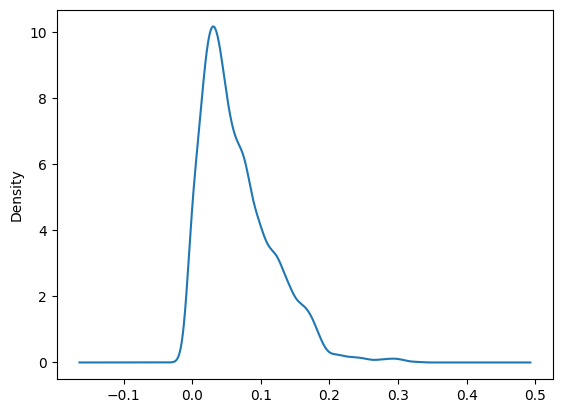

In [1153]:
train['Item_Visibility'].plot(kind='kde')

<Axes: ylabel='Density'>

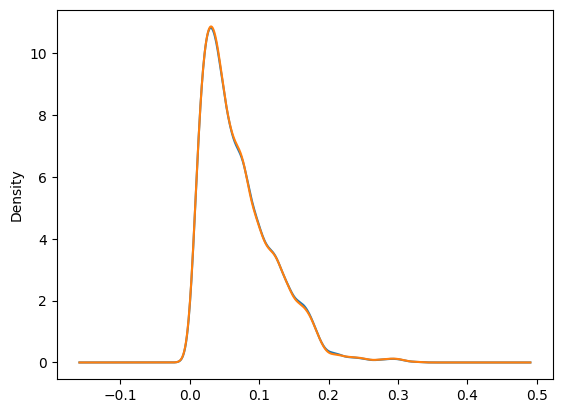

In [1154]:
train['Item_Visibility']=train['Item_Visibility'].replace(to_replace=0.000000,value=np.nan)
train['Item_Visibility_new']= train['Item_Visibility'].fillna(train.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))
train['Item_Visibility_new'].plot(kind='kde')
train['Item_Visibility'].plot(kind='kde')

In [1155]:
train['Item_Visibility_new'].value_counts()

Item_Visibility_new
0.121880    4
0.027777    3
0.029511    3
0.081428    3
0.016164    3
           ..
0.046559    1
0.073525    1
0.014568    1
0.070646    1
0.044878    1
Name: count, Length: 8322, dtype: int64

<Axes: ylabel='Density'>

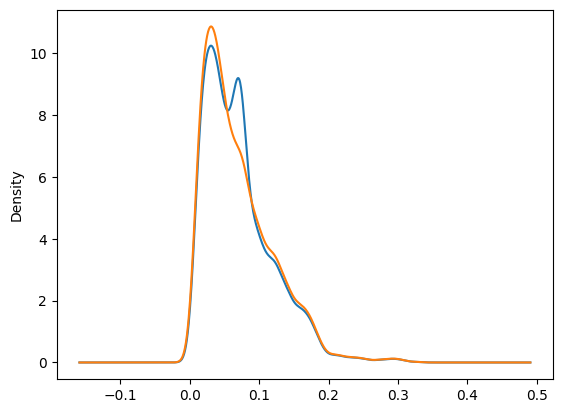

In [1156]:
train['Item_Visibility_Item_type']= train['Item_Visibility'].fillna(train.groupby('Item_Type')['Item_Visibility'].transform('mean'))
train['Item_Visibility_Item_type'].plot(kind='kde')
train['Item_Visibility'].plot(kind='kde')

In [1157]:
# So Item_Visibility is explain better imputed when used Item_Identifier 

In [1158]:
train['Item_Type'].value_counts()# so this looks fine 

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

<Axes: ylabel='Density'>

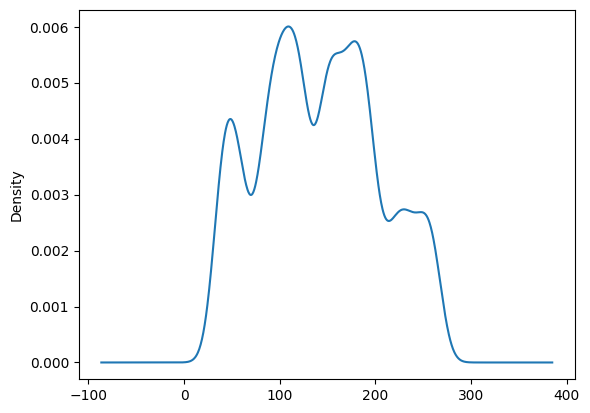

In [1159]:
train['Item_MRP'].plot(kind='kde')# the data distribution shows multiple up and down so probably the distibution
# is like multimodal distribution

In [1160]:
# logic to calculate outliers based on Z-score formula and a value is considered as outlier when the value lies outside
# three standered distribution

y=[]
def find_outliers(a):
    threshold=3
    mean=np.mean(a)
    std=np.std(a)
    for i in a:
        z_score=(i-mean)/std
        if abs(z_score)>threshold:
            y.append(i)
    return len(y)
print(find_outliers(train['Item_MRP']))

0


<Axes: ylabel='Item_MRP'>

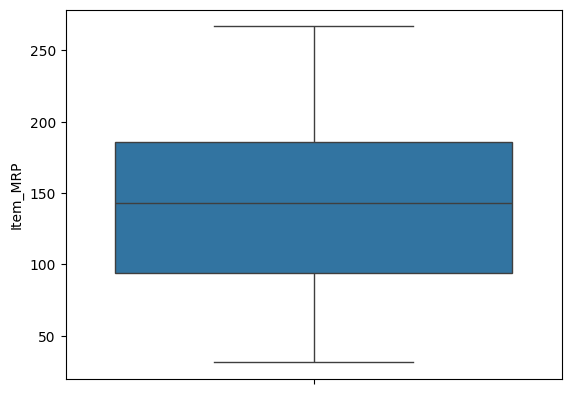

In [1161]:
sns.boxplot(data=train['Item_MRP'])# So no considerable outliers detected so the data looks fine

In [1162]:
train['Outlet_Identifier'].value_counts()# data looks fine

Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64

In [1163]:
train['Outlet_Establishment_Year'].value_counts()# it highlights the establishment year of the outlets

Outlet_Establishment_Year
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: count, dtype: int64

In [1164]:
#we can substract it from current year
train['Outlet_Establishment_Year_new'] = date.today().year-train['Outlet_Establishment_Year']

In [1165]:
train['Outlet_Establishment_Year_new'].value_counts()

Outlet_Establishment_Year_new
40    1463
38     932
26     930
28     930
21     930
23     929
16     928
18     926
27     555
Name: count, dtype: int64

In [1166]:
# So now we need to impute Outlet_Size based on Outlet_Location_Type and Outlet_Type as this columns are very appropriate to use to impute
# Outlet_Size


In [1167]:
train['Outlet_Location_Type'].value_counts(),train['Outlet_Type'].value_counts()

(Outlet_Location_Type
 Tier 3    3350
 Tier 2    2785
 Tier 1    2388
 Name: count, dtype: int64,
 Outlet_Type
 Supermarket Type1    5577
 Grocery Store        1083
 Supermarket Type3     935
 Supermarket Type2     928
 Name: count, dtype: int64)

In [1168]:
train.groupby(['Outlet_Size','Outlet_Location_Type','Outlet_Type']).size()

Outlet_Size  Outlet_Location_Type  Outlet_Type      
High         Tier 3                Supermarket Type1    932
Medium       Tier 1                Supermarket Type1    930
             Tier 3                Supermarket Type2    928
                                   Supermarket Type3    935
Small        Tier 1                Grocery Store        528
                                   Supermarket Type1    930
             Tier 2                Supermarket Type1    930
dtype: int64

In [1169]:
train.groupby(['Outlet_Size','Outlet_Location_Type']).size()

Outlet_Size  Outlet_Location_Type
High         Tier 3                   932
Medium       Tier 1                   930
             Tier 3                  1863
Small        Tier 1                  1458
             Tier 2                   930
dtype: int64

In [1170]:
train.groupby(['Outlet_Size','Outlet_Type']).size()

Outlet_Size  Outlet_Type      
High         Supermarket Type1     932
Medium       Supermarket Type1     930
             Supermarket Type2     928
             Supermarket Type3     935
Small        Grocery Store         528
             Supermarket Type1    1860
dtype: int64

In [1171]:
train_outletsize_blank = train[train['Outlet_Size'].isna()]

In [1172]:
train_outletsize_blank.groupby(['Outlet_Location_Type','Outlet_Type']).size()

Outlet_Location_Type  Outlet_Type      
Tier 2                Supermarket Type1    1855
Tier 3                Grocery Store         555
dtype: int64

In [1096]:
# so from the above combinations we can see that Tier2 with Supermarket type1 has only outlet size Small(930)
# For Tier 3 with Grocery Store the combination is not available but from the above data we can see that Grocery Store are always Small

# So In both the condition we can see that ideally we have to replace with Small

In [1097]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  8523 non-null   object 
 1   Item_Weight                      7060 non-null   float64
 2   Item_Fat_Content                 8523 non-null   object 
 3   Item_Visibility                  7997 non-null   float64
 4   Item_Type                        8523 non-null   object 
 5   Item_MRP                         8523 non-null   float64
 6   Outlet_Identifier                8523 non-null   object 
 7   Outlet_Establishment_Year        8523 non-null   int64  
 8   Outlet_Size                      6113 non-null   object 
 9   Outlet_Location_Type             8523 non-null   object 
 10  Outlet_Type                      8523 non-null   object 
 11  Item_Outlet_Sales                8523 non-null   float64
 12  Item_Identifier_cata

In [1098]:
dic = {'Grocery Store':'Small'}
s = train.Outlet_Type.map(dic)
train.Outlet_Size= train.Outlet_Size.combine_first(s)
train.Outlet_Size.value_counts()

Outlet_Size
Small     2943
Medium    2793
High       932
Name: count, dtype: int64

In [1173]:
train.isnull().sum()

Item_Identifier                       0
Item_Weight                        1463
Item_Fat_Content                      0
Item_Visibility                     526
Item_Type                             0
Item_MRP                              0
Outlet_Identifier                     0
Outlet_Establishment_Year             0
Outlet_Size                        2410
Outlet_Location_Type                  0
Outlet_Type                           0
Item_Outlet_Sales                     0
Item_Identifier_catagory              0
Item_Weight_based_on_identifier       0
Item_Weight_new                       0
Item_Weight_mean                      0
Item_Weight_interpolate               0
Item_Visibility_new                   0
Item_Visibility_Item_type             0
Outlet_Establishment_Year_new         0
dtype: int64

In [1100]:
# train.isnull().sum()

Item_Identifier                       0
Item_Weight                        1463
Item_Fat_Content                      0
Item_Visibility                     526
Item_Type                             0
Item_MRP                              0
Outlet_Identifier                     0
Outlet_Establishment_Year             0
Outlet_Size                        1855
Outlet_Location_Type                  0
Outlet_Type                           0
Item_Outlet_Sales                     0
Item_Identifier_catagory              0
Item_Weight_based_on_identifier       0
Item_Weight_new                       0
Item_Weight_mean                      0
Item_Weight_interpolate               0
Item_Visibility_new                   0
Item_Visibility_Item_type             0
Outlet_Establishment_Year_new         0
dtype: int64

In [1101]:
dic = {"Tier 2":"Small"}
s = train.Outlet_Location_Type.map(dic)
train.Outlet_Size = train.Outlet_Size.combine_first(s)

In [1102]:
# train['Outlet_Size_new']= train['Outlet_Size']

In [1174]:
train.isnull().sum()

Item_Identifier                       0
Item_Weight                        1463
Item_Fat_Content                      0
Item_Visibility                     526
Item_Type                             0
Item_MRP                              0
Outlet_Identifier                     0
Outlet_Establishment_Year             0
Outlet_Size                        2410
Outlet_Location_Type                  0
Outlet_Type                           0
Item_Outlet_Sales                     0
Item_Identifier_catagory              0
Item_Weight_based_on_identifier       0
Item_Weight_new                       0
Item_Weight_mean                      0
Item_Weight_interpolate               0
Item_Visibility_new                   0
Item_Visibility_Item_type             0
Outlet_Establishment_Year_new         0
dtype: int64

In [1104]:
# train['Outlet_Size_new'].value_counts()

Outlet_Size_new
Small     4798
Medium    2793
High       932
Name: count, dtype: int64

In [1105]:
# train['Outlet_Size_new'].value_counts(),train['Outlet_Size'].value_counts()

(Outlet_Size_new
 Small     4798
 Medium    2793
 High       932
 Name: count, dtype: int64,
 Outlet_Size
 Small     4798
 Medium    2793
 High       932
 Name: count, dtype: int64)

In [1106]:
train['Outlet_Type'].value_counts()

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64

In [1175]:
train['Outlet_Size'].value_counts()

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [1107]:
# imputing the outlet size based on outlet type

In [1176]:
pivot_output = train.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x:x.mode()[0]))
missing_val = train['Outlet_Size'].isnull()
train.loc[missing_val,'Outlet_Size']= train.loc[missing_val,'Outlet_Type'].apply(lambda x:pivot_output[x])

In [1179]:
train['Outlet_Size'].value_counts()

Outlet_Size
Small     4798
Medium    2793
High       932
Name: count, dtype: int64

In [1180]:
catagorical_columns_list = ['Item_Identifier','Item_Identifier_catagory','Item_Fat_Content','Item_Type','Outlet_Type','Outlet_Location_Type','Outlet_Size','Outlet_Identifier']

In [1181]:
numerical_columns_list = ['Item_Weight_based_on_identifier','Item_Visibility_new','Outlet_Establishment_Year_new','Item_MRP','Item_Outlet_Sales']

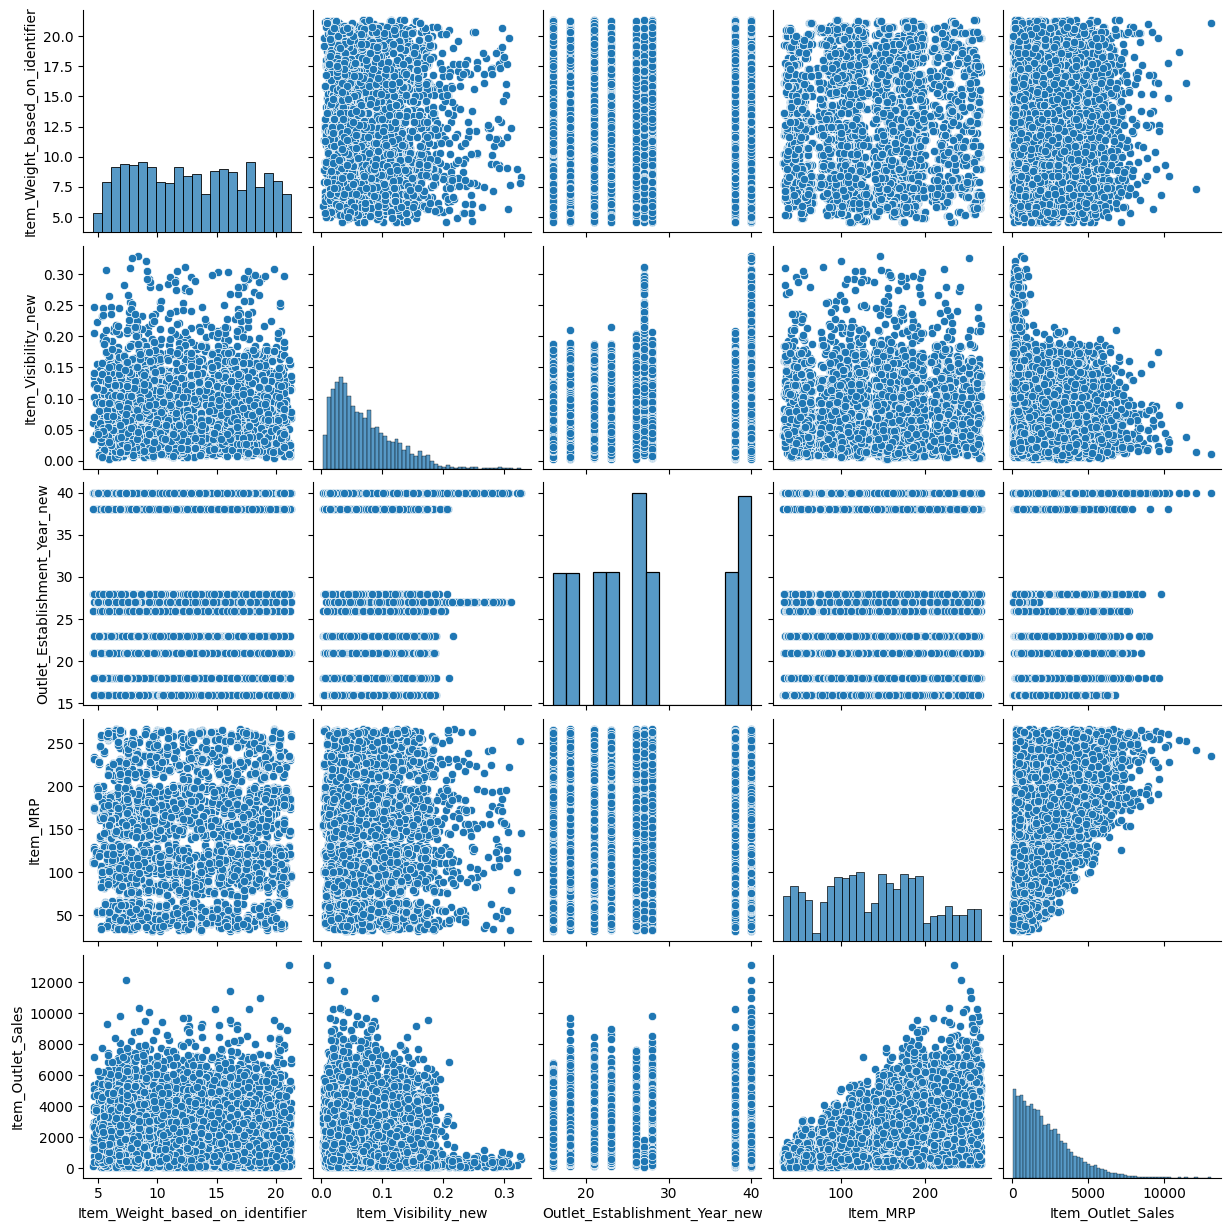

In [1182]:
sns.pairplot(train[numerical_columns_list])# Displaying the numerical column data distribution and their corelation

<Axes: ylabel='Density'>

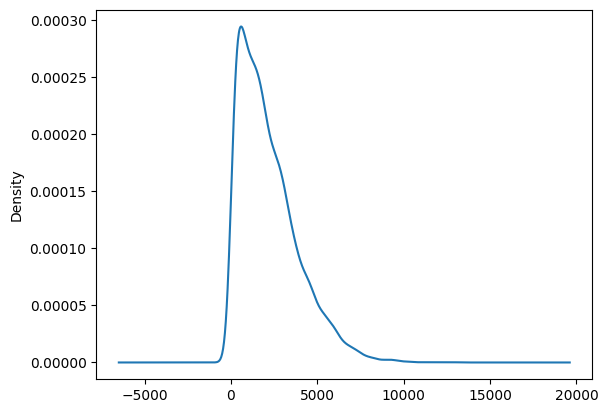

In [1183]:
train['Item_Outlet_Sales'].plot(kind='kde')

<Axes: ylabel='Item_Outlet_Sales'>

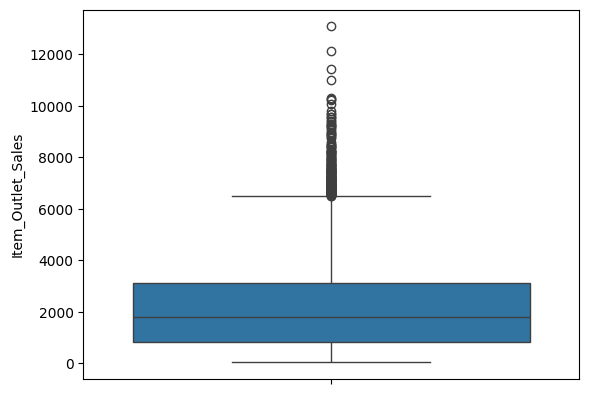

In [1184]:
sns.boxplot(train['Item_Outlet_Sales'])# lot of outliers are there in the output column

In [1185]:
# preparing the catagorical features to be used in the model

In [1186]:
# Linear models might not suit the data distribution as the numerical data is highly scattered and catagorical columns need to be
# onehot encoded which might increase the dimentionality. And Liner models are not great fit if they have so many outliers
# So we will be using tree based models.

In [1187]:
# Use label encoder to encode the catagorical columns

In [1188]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in catagorical_columns_list:
    train[i] = le.fit_transform(train[i])

In [1189]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Weight_new,Item_Weight_mean,Item_Weight_interpolate,Item_Visibility_new,Item_Visibility_Item_type,Outlet_Establishment_Year_new
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380,1,9.30,9.30,9.30,9.30,0.016047,0.016047,26
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228,0,5.92,5.92,5.92,5.92,0.019278,0.019278,16
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700,1,17.50,17.50,17.50,17.50,0.016760,0.016760,26
3,1121,19.20,1,NaN,6,182.0950,0,1998,2,2,0,732.3800,1,19.20,19.20,19.20,19.20,0.022911,0.073719,27
4,1297,8.93,0,NaN,9,53.8614,1,1987,0,2,1,994.7052,2,8.93,8.93,8.93,8.93,0.016164,0.064963,38


In [1190]:
catagorical_columns_list 

['Item_Identifier',
 'Item_Identifier_catagory',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Type',
 'Outlet_Location_Type',
 'Outlet_Size',
 'Outlet_Identifier']

In [1192]:
numerical_columns_list

['Item_Weight_based_on_identifier',
 'Item_Visibility_new',
 'Outlet_Establishment_Year_new',
 'Item_MRP',
 'Item_Outlet_Sales']

In [1447]:
train_final= train[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [1448]:
# train_final= train[['Item_Visibility_new',
                   # 'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [1449]:
train[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Outlet_Sales']].corr()['Item_Outlet_Sales']

Item_Identifier_catagory           0.011236
Item_Weight_based_on_identifier    0.013196
Item_Fat_Content                   0.018719
Item_Visibility_new               -0.126026
Item_Type                          0.017048
Item_MRP                           0.567574
Outlet_Establishment_Year_new      0.049135
Outlet_Size                       -0.162753
Outlet_Location_Type               0.089367
Outlet_Type                        0.401522
Item_Outlet_Sales                  1.000000
Name: Item_Outlet_Sales, dtype: float64

In [1450]:
train_output = np.log1p(train['Item_Outlet_Sales'])

In [1451]:
# train_output = train['Item_Outlet_Sales']

In [1452]:
x_train,x_test,y_train,y_test = train_test_split(train_final,train_output,test_size= .30,random_state = 42)

In [1453]:
# Using XGBOOST

In [1468]:
modelXGB = XGBRegressor(
    n_estimators=2000,          # more boosting rounds for smoother learning
    learning_rate=0.01,         # slower learning for stability in log space
    max_depth=5,                # not too deep to avoid overfit
    min_child_weight=1,         # smaller so it can learn finer patterns
    subsample=0.8,              
    colsample_bytree=0.8,       
    reg_alpha=1,              # mild L1 regularization
    reg_lambda=20,              # reasonable L2 shrinkage
    gamma=1.5,                  # allow more splits
    objective='reg:squarederror',
    random_state=41
)

In [1469]:
modelXGB.fit(x_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [1470]:
score = cross_val_score(modelXGB,train_final,train_output,cv = 5, scoring = 'r2')

In [1471]:
modelXGB.score(x_test,y_test)

0.744926451281637

In [1472]:
y_pred = modelXGB.predict(x_test)

In [1473]:
np.sqrt(metrics.mean_squared_error(y_pred,y_test))

np.float64(0.5186045103443987)

In [1474]:
y_pred1 = np.expm1(y_pred)
y_test1 = np.expm1(y_test)

In [1475]:
np.min(y_pred)

np.float32(4.435114)

In [1476]:
score

array([0.73342504, 0.7291211 , 0.73007796, 0.73294864, 0.7589055 ])

In [1477]:
np.sqrt(metrics.mean_squared_error(y_pred1,y_test1))

np.float64(1075.6657432260984)

In [ ]:
# doing hyperparameter training

In [777]:
param_grid = {
    # Tree complexity
    'max_depth': [3, 4, 5, 6, 8, 10, 12],
    'min_child_weight': [1, 3, 5, 7, 10],
    
    # Regularization
    'gamma': [0, 0.1, 0.2, 0.3, 0.5, 1],
    'reg_alpha': [0, 0.01, 0.1, 1, 5, 10],
    'reg_lambda': [0.1, 1, 5, 10, 20],
    
    # Sampling
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    
    # Learning rate and number of estimators
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 500],
    
    
}

In [778]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,                # number of combinations to try
    cv=5,
    verbose=2,
    random_state=42,

)

In [779]:
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, ma

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.5, 0.6, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [784]:
random_search.best_params_

{'subsample': 0.5,
 'reg_lambda': 20,
 'reg_alpha': 5,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.01,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [785]:
best_xgb_model=random_search.best_estimator_

In [786]:
best_xgb_model.score(x_test,y_test)

0.6135742084327875

In [787]:
pred_xgb_best=best_xgb_model.predict(x_test)

In [788]:
np.min(pred_xgb_best)

np.float32(97.36197)

In [789]:
np.sqrt(metrics.mean_squared_error(pred_xgb_best,y_test))# 1016 is the RMSE value

np.float64(1024.8383943082715)

In [ ]:
# Randomforest

In [527]:
param_grid = { 'min_samples_leaf':[1,2,3,4],'min_samples_split':[2,3,4,6], 'bootstrap': [True], 'max_depth': [4,6,10,50], 
               'n_estimators': [10,20,50,100,150]}

In [529]:
rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,                # number of combinations to try
    
    cv=5,
    random_state=42,

)

In [530]:
random_search_rf.fit(x_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'bootstrap': [True], 'max_depth': [4, 6, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 3, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [780]:
best_rf_model=random_search_rf.best_estimator_

In [781]:
random_search_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 6,
 'bootstrap': True}

In [782]:
pred_rf_best=best_rf_model.predict(x_test)
np.min(pred_rf_best)

np.float64(67.73403486140629)

In [783]:
np.sqrt(metrics.mean_squared_error(pred_rf_best,y_test))

np.float64(1020.4116149662949)

In [ ]:
#checking if avg of the prediction of both xgboost and random forest

In [368]:
pred_rf_best

array([1207.67986463,  654.44427739,  655.54338655, ...,  655.54338655,
        739.28007891, 1660.05241563], shape=(1705,))

In [369]:
pred_xgb_best

array([1309.6497 ,  721.0791 ,  719.0276 , ...,  722.47943,  635.6536 ,
       1669.2079 ], shape=(1705,), dtype=float32)

In [370]:
final_pred = (pred_rf_best+pred_xgb_best)/2

In [371]:
final_pred

array([1258.66476141,  687.76168947,  687.28548722, ...,  689.01140885,
        687.4668522 , 1664.63015069], shape=(1705,))

In [373]:
np.sqrt(metrics.mean_squared_error(final_pred,y_test))

np.float64(1016.1588107390928)

In [ ]:
# create prediction on test file

In [1333]:
test = pd.read_csv("test_AbJTz2l.csv")

In [1334]:
test

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3
...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1
5677,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2
5678,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1
5679,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [1331]:
# train_final= train[['Item_Visibility_new',
#                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [1335]:
test['Item_Identifier_catagory'] = test['Item_Identifier'].str[:2]
test['Item_Weight_based_on_identifier'] = test['Item_Weight'].fillna(
    test.groupby('Item_Identifier')['Item_Weight'].transform('mean')
)
test['Item_Weight_based_on_identifier'] = test['Item_Weight_based_on_identifier'].fillna(
    test.groupby(['Item_Identifier_catagory', 'Item_Type'])['Item_Weight_based_on_identifier'].transform('mean')
)
test['Item_Fat_Content'] = test['Item_Fat_Content'].map({
    'Low Fat': 'Low Fat',
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular',
    'Regular': 'Regular'
})
test['Item_Visibility']=test['Item_Visibility'].replace(to_replace=0.000000,value=np.nan)
test['Item_Visibility_new']= test['Item_Visibility'].fillna(test.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))
test['Outlet_Establishment_Year_new'] = date.today().year-test['Outlet_Establishment_Year']
pivot_output = test.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x:x.mode()[0]))
missing_val = test['Outlet_Size'].isnull()
test.loc[missing_val,'Outlet_Size']= test.loc[missing_val,'Outlet_Type'].apply(lambda x:pivot_output[x])

test['Outlet_Size_new']= test['Outlet_Size'].fillna("Small")
test['Outlet_Identifier_new'] = test['Outlet_Identifier']

In [1318]:
# test_final= test[['Item_Visibility_new',
#                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [1336]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  5681 non-null   object 
 1   Item_Weight                      4705 non-null   float64
 2   Item_Fat_Content                 5681 non-null   object 
 3   Item_Visibility                  5328 non-null   float64
 4   Item_Type                        5681 non-null   object 
 5   Item_MRP                         5681 non-null   float64
 6   Outlet_Identifier                5681 non-null   object 
 7   Outlet_Establishment_Year        5681 non-null   int64  
 8   Outlet_Size                      5681 non-null   object 
 9   Outlet_Location_Type             5681 non-null   object 
 10  Outlet_Type                      5681 non-null   object 
 11  Item_Identifier_catagory         5681 non-null   object 
 12  Item_Weight_based_on

<Axes: ylabel='Density'>

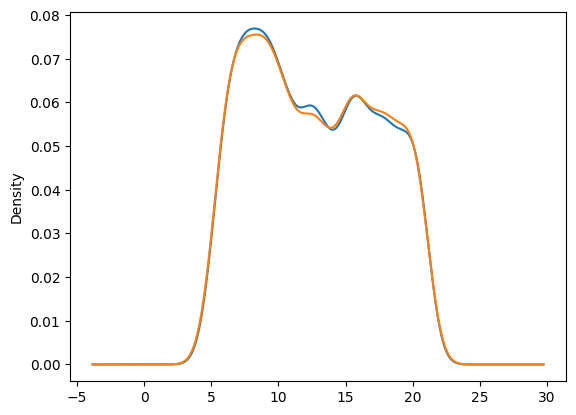

In [965]:
test['Item_Weight_based_on_identifier'].plot(kind='kde')
test['Item_Weight'].plot(kind='kde')

<Axes: ylabel='Density'>

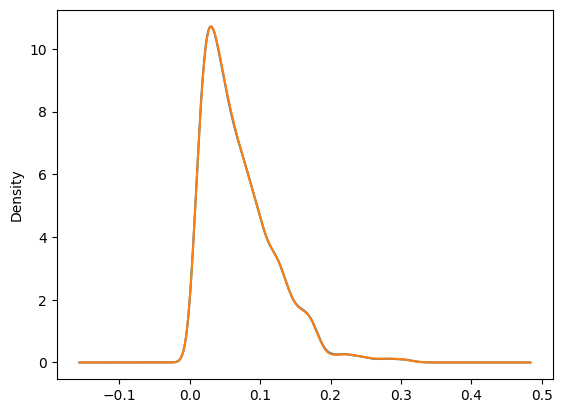

In [966]:
test['Item_Visibility_new'].plot(kind='kde')
test['Item_Visibility'].plot(kind='kde')

In [967]:
test['Outlet_Size_new'].value_counts()

Outlet_Size_new
Small     3198
Medium    1862
High       621
Name: count, dtype: int64

In [1337]:
catagorical_columns_list = ['Item_Identifier_catagory','Item_Identifier_catagory','Item_Fat_Content','Item_Type','Outlet_Type','Outlet_Location_Type','Outlet_Size','Outlet_Identifier']
numerical_columns_list = ['Item_Weight_based_on_identifier','Item_Visibility_new','Outlet_Establishment_Year_new','Item_MRP','Item_Outlet_Sales']

In [1338]:
for i in catagorical_columns_list:
    test[i] = le.fit_transform(test[i])

In [1339]:
 test_final= test[['Item_Visibility_new',
                  'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [1340]:
test_final

,Item_Visibility_new,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.007565,107.8622,26,1,0,1
1,0.038428,87.3198,18,2,1,1
2,0.099575,241.7538,27,2,2,0
3,0.015388,155.0340,18,2,1,1
4,0.118599,234.2300,40,1,2,3
...,...,...,...,...,...,...
5676,0.013496,141.3154,28,2,0,1
5677,0.142991,169.1448,16,1,2,2
5678,0.073529,118.7440,23,2,1,1
5679,0.114971,214.6218,18,2,1,1


In [971]:
# test_final= test[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
#                     'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size_new','Outlet_Location_Type','Outlet_Type']]

In [729]:
rf = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=None,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
rf.fit(x_train,y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1342]:
test['Item_Outlet_Sales'] = np.expm1(modelXGB.predict(test_final))

In [1344]:
test

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Visibility_new,Outlet_Establishment_Year_new,Outlet_Identifier_new,Item_Outlet_Sales
0,FDW58,20.750,0,0.007565,13,107.8622,9,1999,1,0,1,1,20.750,0.007565,26,OUT049,1511.907104
1,FDW14,8.300,1,0.038428,4,87.3198,2,2007,2,1,1,1,8.300,0.038428,18,OUT017,1264.542480
2,NCN55,14.600,0,0.099575,11,241.7538,0,1998,2,2,0,2,14.600,0.099575,27,OUT010,499.806793
3,FDQ58,7.315,0,0.015388,13,155.0340,2,2007,2,1,1,1,7.315,0.015388,18,OUT017,2249.669922
4,FDY38,NaN,1,0.118599,4,234.2300,5,1985,1,2,3,1,13.600,0.118599,40,OUT027,4983.967285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,1,0.013496,13,141.3154,8,1997,2,0,1,1,10.500,0.013496,28,OUT046,1889.701172
5677,FDD47,7.600,1,0.142991,15,169.1448,3,2009,1,2,2,1,7.600,0.142991,16,OUT018,2229.596680
5678,NCO17,10.000,0,0.073529,8,118.7440,7,2002,2,1,1,2,10.000,0.073529,23,OUT045,1734.593994
5679,FDJ26,15.300,1,NaN,3,214.6218,2,2007,2,1,1,1,15.300,0.114971,18,OUT017,3089.699951


In [1345]:
df = test[['Item_Identifier','Outlet_Identifier_new','Item_Outlet_Sales']]

In [1346]:
df.rename(columns={'Outlet_Identifier_new': 'Outlet_Identifier'}, inplace=True)

/var/folders/wn/81srscj53qq1qb7nwhl96jr00000gn/T/ipykernel_34864/1629070506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Outlet_Identifier_new': 'Outlet_Identifier'}, inplace=True)


In [1347]:
df

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1511.907104
1,FDW14,OUT017,1264.542480
2,NCN55,OUT010,499.806793
3,FDQ58,OUT017,2249.669922
4,FDY38,OUT027,4983.967285
...,...,...,...
5676,FDB58,OUT046,1889.701172
5677,FDD47,OUT018,2229.596680
5678,NCO17,OUT045,1734.593994
5679,FDJ26,OUT017,3089.699951


In [1348]:
df.to_csv("xg_latest_solution.csv", index=False)

In [1349]:
df.sort_values(by='Item_Outlet_Sales', ascending=True)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
30,NCR42,OUT019,98.443092
5016,FDG40,OUT019,98.443092
5450,FDT36,OUT019,98.443092
2798,FDU15,OUT019,98.443092
2522,FDX59,OUT010,98.770866
...,...,...,...
3905,FDS56,OUT027,5081.569336
5615,FDF04,OUT027,5081.569336
5273,NCT05,OUT027,5081.569336
4921,FDN51,OUT027,5081.569336


<Axes: >

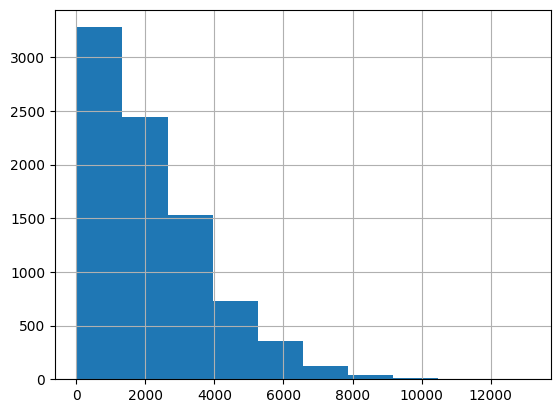

In [927]:
train['Item_Outlet_Sales'].hist()

In [807]:
train['Item_Outlet_Sales'].mean(),train['Item_Outlet_Sales'].median()

(np.float64(2181.288913575032), np.float64(1794.331))

In [808]:
train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Item_Outlet_Sales,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Weight_new,Item_Weight_mean,Item_Weight_interpolate,Item_Visibility_new,Item_Visibility_Item_type,Outlet_Establishment_Year_new,Outlet_Size_new
0,FDA15,9.300,0,0.016047,4,249.8092,9,1999,Medium,0,...,3735.1380,1,9.300,9.300,9.300,9.300,0.016047,0.016047,26,1
1,DRC01,5.920,1,0.019278,14,48.2692,3,2009,Medium,2,...,443.4228,0,5.920,5.920,5.920,5.920,0.019278,0.019278,16,1
2,FDN15,17.500,0,0.016760,10,141.6180,9,1999,Medium,0,...,2097.2700,1,17.500,17.500,17.500,17.500,0.016760,0.016760,26,1
3,FDX07,19.200,1,NaN,6,182.0950,0,1998,Small,2,...,732.3800,1,19.200,19.200,19.200,19.200,0.022911,0.073719,27,2
4,NCD19,8.930,0,NaN,9,53.8614,1,1987,High,2,...,994.7052,2,8.930,8.930,8.930,8.930,0.016164,0.064963,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,0,0.056783,13,214.5218,1,1987,High,2,...,2778.3834,1,6.865,6.865,6.865,6.865,0.056783,0.056783,38,0
8519,FDS36,8.380,1,0.046982,0,108.1570,7,2002,Small,1,...,549.2850,1,8.380,8.380,8.380,8.380,0.046982,0.046982,23,2
8520,NCJ29,10.600,0,0.035186,8,85.1224,6,2004,Small,1,...,1193.1136,2,10.600,10.600,10.600,10.600,0.035186,0.035186,21,2
8521,FDN46,7.210,1,0.145221,13,103.1332,3,2009,Medium,2,...,1845.5976,1,7.210,7.210,7.210,7.210,0.145221,0.145221,16,1


In [928]:
min(train['Item_Outlet_Sales'])

33.29

In [929]:
max(train['Item_Outlet_Sales'])

13086.9648

<Axes: >

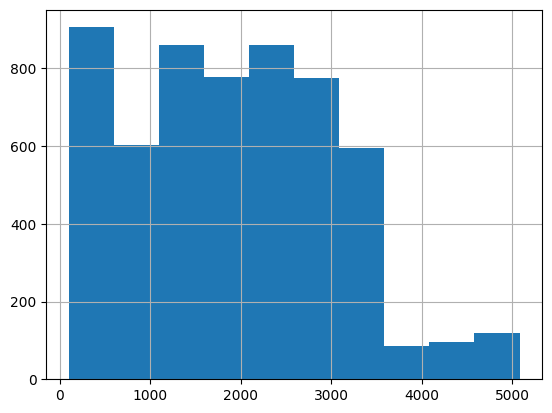

In [1350]:
df.Item_Outlet_Sales.hist()

In [946]:
train[train['Item_Outlet_Sales']<3000]['Item_Outlet_Sales'].mean()

np.float64(1345.4242085344413)

In [948]:
train['Item_Outlet_Sales'].mean()

np.float64(2181.288913575032)